In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing libraries
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    logging,
    pipeline,
)



In [ ]:
# defining variables
DATA_DIR = "/kaggle/input/language-detection/"
MODEL_NAME = "bert-base-multilingual-uncased"
RANDOM_STATE = 12345
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 1
LEARNING_RATE = 5e-5

torch.backends.cudnn.deterministic = True
torch.manual_seed(RANDOM_STATE)
logging.set_verbosity_error()

In [ ]:
# Displaying the device used for fune-tuning BERT
print(f"Device used: {DEVICE}")

Device used: cuda


In [ ]:
# Loading the data
df = pd.read_csv("/content/drive/MyDrive/Language Detection.csv")

# Displaying random 30 rows
df.sample(n=30, random_state=RANDOM_STATE)

,Text,Language
1346,oh dear one night when she was sleeping her mo...,English
2184,சந்திப்பு அல்லது தேதி என்று சொல்வது மிகவும் பி...,Tamil
4718,wat dacht je van een ijsje?,Dutch
1041,i'm deluged with assignments smart word number...,English
6772,"han er så klar og suave, især foran damerne el...",Danish
6983,Jeg har ikke en mening om sagen.,Danish
2374,"என்னைப் பொருத்தவரை, இது நகரத்தின் சிறந்த உணவகம்.",Tamil
4856,Existe cierta polémica entre los fundadores de...,Spanish
4209,Veuillez accepter mes excuses.,French
7140,Wales cedette tutti i diritti alla fondazione ...,Italian


In [ ]:
# Describing the data
df.describe()

,Text,Language
count,10337,10337
unique,10267,17
top,Jag är ledsen.,English
freq,3,1385


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Language').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Language'].value_counts()
    for x_label, grp in _df_2.groupby('Text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Text')
_ = plt.ylabel('Language')

In [ ]:
# data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


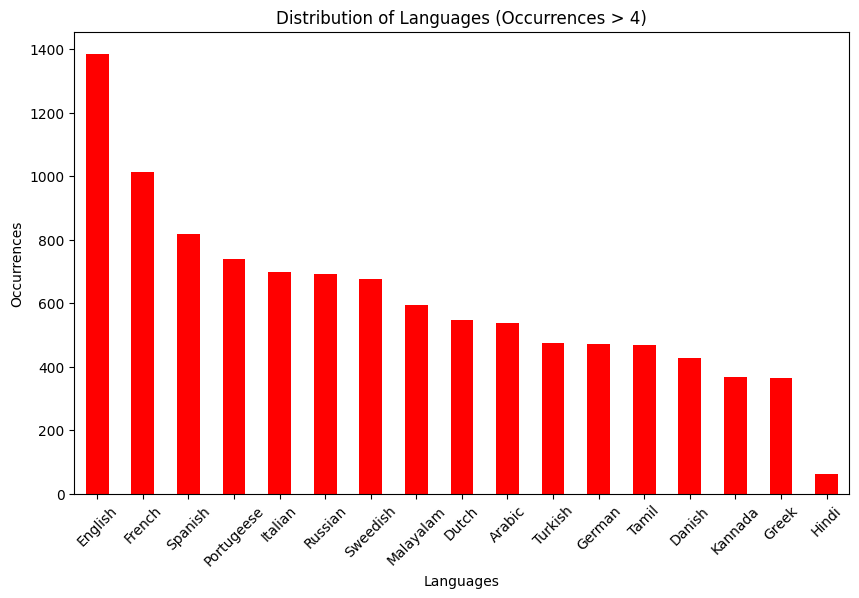

In [ ]:
# Count the occurrences of each language in our df
language_counts = df['Language'].value_counts()
# Plot the bar plot
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', color='red')
plt.title('Distribution of Languages (Occurrences > 4)')
plt.xlabel('Languages')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.show()

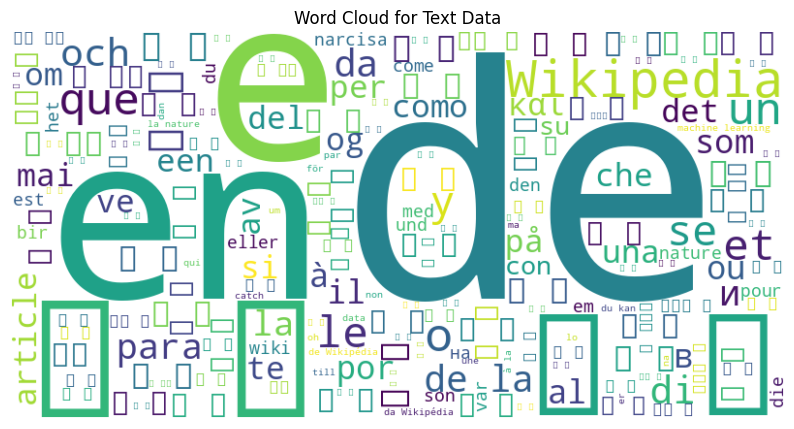

In [ ]:
from wordcloud import WordCloud
# Concatenate all text data
all_text = ' '.join(df['Text'])
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Text Data')
plt.axis('off')
plt.show()

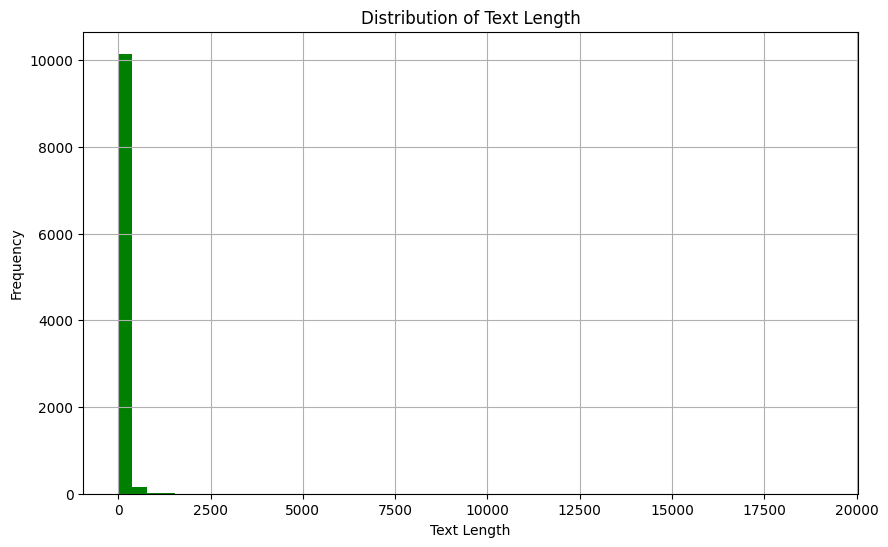

In [ ]:
# Length distribution graph
plt.figure(figsize=(10, 6))
df['Text'].apply(len).hist(color='green', bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

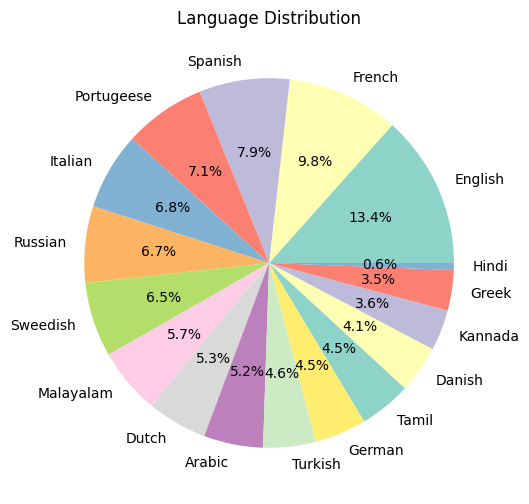

In [ ]:
# Language distribution graph
plt.figure(figsize=(10, 6))
df['Language'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Language Distribution')
plt.ylabel('')
plt.show()

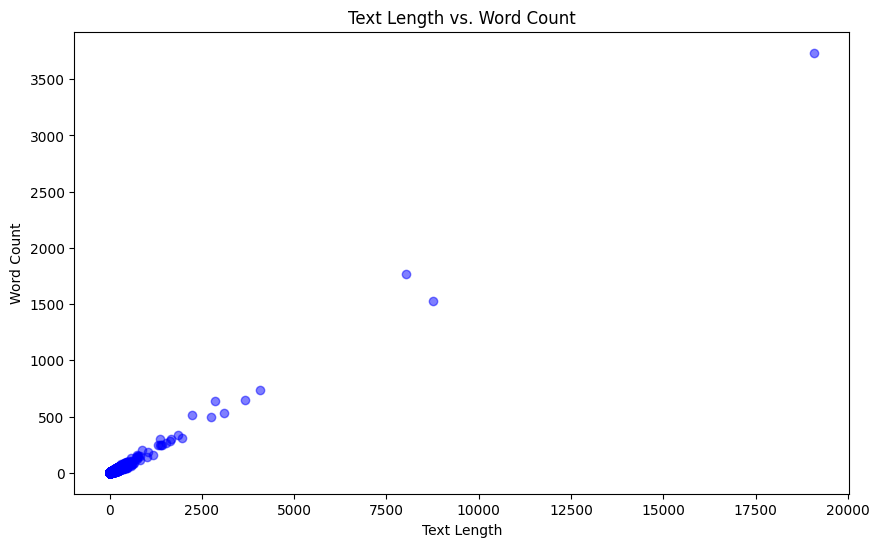

In [ ]:
# word count graph
word_counts = df['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.scatter(df['Text'].apply(len), word_counts, color='blue', alpha=0.5)
plt.title('Text Length vs. Word Count')
plt.xlabel('Text Length')
plt.ylabel('Word Count')
plt.show()

BERT MODEL

In [ ]:
# Retrieving the text data
texts_data = df["Text"].values.astype("U")

# Retrieving the labels data
labels_data = df["Language"].values

In [ ]:
# Instantiating the LabelEncoder object
label_encoder = LabelEncoder()

# Encoding the labels
labels_data_encoded = label_encoder.fit_transform(labels_data)
class_names = label_encoder.classes_

# Displaying the encoding results
for idx, class_name in enumerate(class_names):
    print(f"{idx:<2} => {class_name}")

0  => Arabic
1  => Danish
2  => Dutch
3  => English
4  => French
5  => German
6  => Greek
7  => Hindi
8  => Italian
9  => Kannada
10 => Malayalam
11 => Portugeese
12 => Russian
13 => Spanish
14 => Sweedish
15 => Tamil
16 => Turkish


In [ ]:
# Separating data into training set and validation/test sets
(
training_texts,
validation_testing_texts,
training_labels,
validation_testing_labels
) = train_test_split(
    texts_data,
    labels_data_encoded,
    train_size=0.8,
    random_state=RANDOM_STATE,
    stratify=labels_data_encoded,
)

# Separating validation and test sets
(
validation_texts,
testing_texts,
validation_labels,
testing_labels
) = train_test_split(
    validation_testing_texts,
    validation_testing_labels,
    train_size=0.5,
    random_state=RANDOM_STATE,
    stratify=validation_testing_labels,
)

In [ ]:
import pandas as pd
test_set = pd.DataFrame({'text': testing_texts, 'label': testing_labels})

# Save the test set to a CSV file
test_set.to_csv('test_set_labeled_bert.csv', index=False)

In [ ]:
# Verifying the correctness of dimensions
assert (
    training_texts.shape[0] + validation_texts.shape[0] + testing_texts.shape[0] \
    == texts_data.shape[0]
)

# Displaying the number of objects in each set
training_texts.shape[0], validation_texts.shape[0], testing_texts.shape[0]

(8269, 1034, 1034)

In [ ]:
# Instantiating a BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [ ]:
# Tokenizing the training examples
training_encodings = bert_tokenizer(
    list(training_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length",
)

# Tokenizing the validation examples
validation_encodings = bert_tokenizer(
    list(validation_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length",
)

# Tokenizing the testing examples
testing_encodings = bert_tokenizer(
    list(testing_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length",
)


In [ ]:
def display_encodings_info(
    tokenizer,
    encodings,
    texts,
    labels,
    text_idx
):
    """Shows the original, encoded and decoded texts."""
    # Displaying the original text
    text = texts[text_idx]
    print(f"Input text:\n{text}\n")

    # Displaying the language of the text
    lang_label = labels[text_idx]
    lang = class_names[lang_label]
    print(f"Language: {lang}\n")

    # Displaying the encoded text
    text_encoded = encodings["input_ids"][text_idx]
    print(f"Tokenized input text (encoded):\n{text_encoded}\n")

    # Displaying the decoded text
    text_decoded = tokenizer.convert_ids_to_tokens(text_encoded)
    print(f"Tokenized input text (decoded):\n{text_decoded}")

In [ ]:
display_encodings_info(
    tokenizer=bert_tokenizer,
    encodings=training_encodings,
    texts=training_texts,
    labels=training_labels,
    text_idx=990,
)

Input text:
est une façon très française de dire réunion ou date par exemple j'ai rendez-vous avec mes amis pendant le déjeuner le samedi ou je prévois de rendez-vous avec mes amis au centre commercial pour les films rendez-vous peut être utilisé à la fois comme nom ou comme verbe par exemple.

Language: French

Tokenized input text (encoded):
[101, 10182, 10249, 28495, 10860, 13903, 10102, 18759, 22600, 10391, 13114, 10263, 15129, 152, 112, 11279, 74427, 118, 22812, 10516, 11019, 32378, 14055, 10130, 10102, 10378, 18712, 10131, 10130, 11714, 10777, 10391, 10149, 12021, 88710, 10102, 74427, 118, 22812, 10516, 11019, 32378, 10257, 11534, 16229, 10343, 10152, 13076, 74427, 118, 22812, 12835, 11787, 18814, 143, 10106, 13488, 11043, 11542, 10391, 11043, 49896, 10111, 10263, 15129, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokenized input te

In [ ]:
display_encodings_info(
    tokenizer=bert_tokenizer,
    encodings=validation_encodings,
    texts=validation_texts,
    labels=validation_labels,
    text_idx=1033,
)

Input text:
Essa foi a primeira enciclopédia interativa (e também foi o primeiro grande documento multimídia conectado através de links internos), sendo a maioria dos artigos acessíveis através de um mapa interativo do Reino Unido.

Language: Portugeese

Tokenized input text (encoded):
[101, 18416, 10464, 143, 13664, 36286, 49487, 16689, 113, 147, 12014, 10464, 157, 13552, 11031, 34132, 17682, 10555, 14302, 64100, 92300, 20712, 10102, 21313, 93117, 114, 117, 14297, 143, 24112, 10426, 72480, 29552, 32297, 29530, 20712, 10102, 10316, 20777, 49487, 17391, 10154, 14855, 19957, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokenized input text (decoded):
['[CLS]', 'essa', 'foi', 'a', 'primeira', 'enciclopedia', 'intera', '##tiva', '(', 'e', 'tambem', 'foi', 'o', 'primeiro', 'grande',

In [ ]:
class LanguageDataset(Dataset):
    """Class for creating a custom dataset."""

    def __init__(self, encodings, labels):
        """Constructor for LanguageDataset class."""
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        """Computes the number of the dataset objects."""
        dataset_length = len(self.labels)

        return dataset_length

    def __getitem__(self, idx):
        """Returns the corresponding samples for index given."""
        item = {key: torch.tensor(value[idx])
                for key, value in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])

        return item


In [ ]:
# Initializing the training dataset
training_dataset = LanguageDataset(
    encodings=training_encodings,
    labels=training_labels,
)

# Initializing the validation dataset
validation_dataset = LanguageDataset(
    encodings=validation_encodings,
    labels=validation_labels,
)

# Initializing the testing dataset
testing_dataset = LanguageDataset(
    encodings=testing_encodings,
    labels=testing_labels,
)

In [ ]:
# Creating a training Dataloader
training_dataloader = DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Creating a validation Dataloader
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Creating a testing Dataloader
testing_dataloader = DataLoader(
    testing_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [ ]:
print(f"Training data examples: {len(training_dataloader.dataset):,}")
print(f"Number of batches: {len(training_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Training data examples: 8,269
Number of batches: 130
Batch size: 64


In [ ]:
print(f"Validation data examples: {len(validation_dataloader.dataset)}")
print(f"Number of batches: {len(validation_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Validation data examples: 1034
Number of batches: 17
Batch size: 64


In [ ]:
print(f"Testing data examples: {len(testing_dataloader.dataset):,}")
print(f"Number of batches: {len(testing_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Testing data examples: 1,034
Number of batches: 17
Batch size: 64


In [ ]:
# Creating a mapping from predictions to label names
id2label_mappings = dict()
for i, name in enumerate(class_names):
    id2label_mappings[i] = name
id2label_mappings

{0: 'Arabic',
 1: 'Danish',
 2: 'Dutch',
 3: 'English',
 4: 'French',
 5: 'German',
 6: 'Greek',
 7: 'Hindi',
 8: 'Italian',
 9: 'Kannada',
 10: 'Malayalam',
 11: 'Portugeese',
 12: 'Russian',
 13: 'Spanish',
 14: 'Sweedish',
 15: 'Tamil',
 16: 'Turkish'}

In [ ]:
# Computing the number of classes
num_labels = len(class_names)

# Instantiating the BERT model
bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label_mappings,
)

# Moving the model to DEVICE (GPU/CUDA)
bert_model.to(DEVICE)

# Defining the optimization algorithm
optimizer = torch.optim.Adam(bert_model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

In [ ]:
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
def acc_score(model, dataloader, device=DEVICE):
    """Computes the accuracy score for a DataLoader."""
    # Preallocating counter variables
    correct_predictions, num_examples = 0, 0

    # Turning off computing gradients
    with torch.no_grad():

        # Iteratively computing accuracy score (batch by batch)
        for batch_idx, batch in enumerate(dataloader):

            # Selecting the batch data (encodings, attention mask, labels)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Using BERT to compute logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]

            # Computing the predictions for labels
            predicted_labels = torch.argmax(logits, dim=1)

            # Computing the number of examples/correct predictions number
            num_examples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()

    # Computing the final accuracy score
    accuracy_score = correct_predictions.float() / num_examples

    return accuracy_score

In [ ]:
def train_bert_model(
    model,
    optimizer,
    training_dataloader,
    validation_dataloader,
    accuracy_score_func=acc_score,
    epochs=2,
    batch_log_freq=100,
    device=DEVICE
):
    """Launches the fine-tuning of BERT."""
    # Starting the timer
    start_time = time.time()

    # Going through all epochs
    for epoch in range(epochs):

        # Setting the model in the training mode
        model.train()

        # Going through all batches
        for batch_idx, batch in enumerate(training_dataloader):

            # Selecting the batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # BERT forward pass
            outputs = model(
                input_ids, attention_mask=attention_mask, labels=labels
            )
            loss, logits = outputs["loss"], outputs["logits"]

            # BERT backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging the progress
            if not batch_idx % batch_log_freq:
                print (f"Epoch {epoch+1:03d}/{epochs:03d} | "
                       f"Batch {batch_idx:03d}/{len(training_dataloader):03d} | "
                       f"Loss = {loss:.4f}")

        # Setting the model in the evaluation mode
        model.eval()

        # Disabling computing gradients
        with torch.set_grad_enabled(False):
            # Computing training accuracy
            training_accuracy_score = accuracy_score_func(
                model=model,
                dataloader=training_dataloader,
            )
            # Computing validation accuracy
            validation_accuracy_score = accuracy_score_func(
                model=model,
                dataloader=validation_dataloader,
            )
            # Logging the accuracy scores
            print(f"\nTraining accuracy = "
                  f"{training_accuracy_score:.4f}"
                  f"\nValid accuracy = "
                  f"{validation_accuracy_score:.4f}\n")

        # Printing the time passed at the end of the epoch
        time_elapsed_epoch = (time.time() - start_time) / 60
        print(f'Time elapsed: {time_elapsed_epoch:.2f} min\n')

    # Printing the total time spent on BERT fine-tuning
    time_elapsed_total = (time.time() - start_time) / 60
    print(f'\nTotal training Time: {time_elapsed_total:.2f} min')

    return model

In [ ]:
# Training the BERT model
bert_model = train_bert_model(
    model=bert_model,
    optimizer=optimizer,
    training_dataloader=training_dataloader,
    validation_dataloader=validation_dataloader,
    epochs=NUM_EPOCHS,
    batch_log_freq=10,
)

Epoch 001/001 | Batch 000/130 | Loss = 2.8791
Epoch 001/001 | Batch 010/130 | Loss = 1.8869
Epoch 001/001 | Batch 020/130 | Loss = 0.8887
Epoch 001/001 | Batch 030/130 | Loss = 0.4699
Epoch 001/001 | Batch 040/130 | Loss = 0.3394
Epoch 001/001 | Batch 050/130 | Loss = 0.1663
Epoch 001/001 | Batch 060/130 | Loss = 0.2194
Epoch 001/001 | Batch 070/130 | Loss = 0.1994
Epoch 001/001 | Batch 080/130 | Loss = 0.1267
Epoch 001/001 | Batch 090/130 | Loss = 0.2361
Epoch 001/001 | Batch 100/130 | Loss = 0.0598
Epoch 001/001 | Batch 110/130 | Loss = 0.1749
Epoch 001/001 | Batch 120/130 | Loss = 0.0536

Training accuracy = 0.9915
Valid accuracy = 0.9913

Time elapsed: 3.53 min


Total training Time: 3.53 min


In [ ]:
def evaluate_test(model, dataloader, device=DEVICE):
    """Predicts the labels for the DataLoader."""
    # Setting up counter variables
    correct_preds, num_examples = 0, 0
    # Preallocating the list for test predictions
    test_predictions = []

    # Disabling computing gradients
    with torch.no_grad():

        # Iterating through all batches
        for batch_idx, batch in enumerate(dataloader):

            # Selecting the batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Computing logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]

            # Computing the predictions for labels
            predicted_labels_batch = torch.argmax(logits, dim=1)

            # Adding the batch predictions to the list
            test_predictions.append(predicted_labels_batch)

            # Iteratively computing accuracy determinants
            num_examples += labels.size(0)
            correct_preds += (predicted_labels_batch == labels).sum().cpu()

    # Computing final accuracy score
    test_accuracy_score = correct_preds.float() / num_examples

    # Transforming a list of tensors into one tensor
    test_predictions_tensor = torch.cat(test_predictions).cpu()

    return test_accuracy_score, test_predictions_tensor

**Running Test set**

In [ ]:
# Computing test accuracy and test predictions
accuracy_test, predictions_test = evaluate_test(
    model=bert_model, dataloader=testing_dataloader
)

print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.9807


In [ ]:
# testing
# Defining the Transformers pipeline
bert_pipeline = pipeline(
    task="text-classification",
    model=bert_model,
    tokenizer=bert_tokenizer,
    device=DEVICE,
)

In [ ]:
#predicting text
def define_lang_one_text(pipeline, test_text):
    """Outputs the language prediction for a sample text."""
    # Applying the pipeline to make predictions
    one_text_results = pipeline(test_text)[0]
    # Retrieving the probability
    proba = one_text_results["score"]
    # Retrieving the predicted label (encoded)
    predicted_lang = one_text_results["label"]
    # Displaying the prediction
    print(f"Predicted language: {predicted_lang} ({proba:.2%} probability)")

In [ ]:
# Creating a test text (English)
test_text = "It is interesting how we all turned out to be in the same place."
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: It is interesting how we all turned out to be in the same place.

Predicted language: English (98.73% probability)


In [ ]:
print(classification_report(
    y_true=testing_labels,
    y_pred=predictions_test,
    target_names=class_names,
)
     )

              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00        53
      Danish       1.00      0.93      0.96        43
       Dutch       0.92      1.00      0.96        55
     English       1.00      0.99      1.00       139
      French       0.99      0.96      0.97       101
      German       0.96      1.00      0.98        47
       Greek       1.00      1.00      1.00        36
       Hindi       1.00      1.00      1.00         6
     Italian       0.99      0.97      0.98        70
     Kannada       1.00      1.00      1.00        37
   Malayalam       1.00      1.00      1.00        60
  Portugeese       0.95      0.97      0.96        74
     Russian       1.00      0.99      0.99        69
     Spanish       0.93      0.96      0.95        82
    Sweedish       1.00      0.94      0.97        68
       Tamil       1.00      1.00      1.00        47
     Turkish       0.98      1.00      0.99        47

    accuracy              

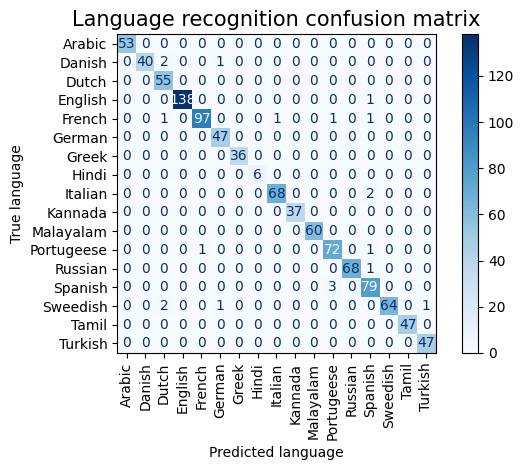

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    testing_labels,
    predictions_test,
    display_labels=class_names,
    cmap="Blues",
)
plt.xticks(rotation=90)
plt.xlabel("Predicted language")
plt.ylabel("True language")
plt.title("Language recognition confusion matrix", fontsize=15)
plt.tight_layout()
plt.show()

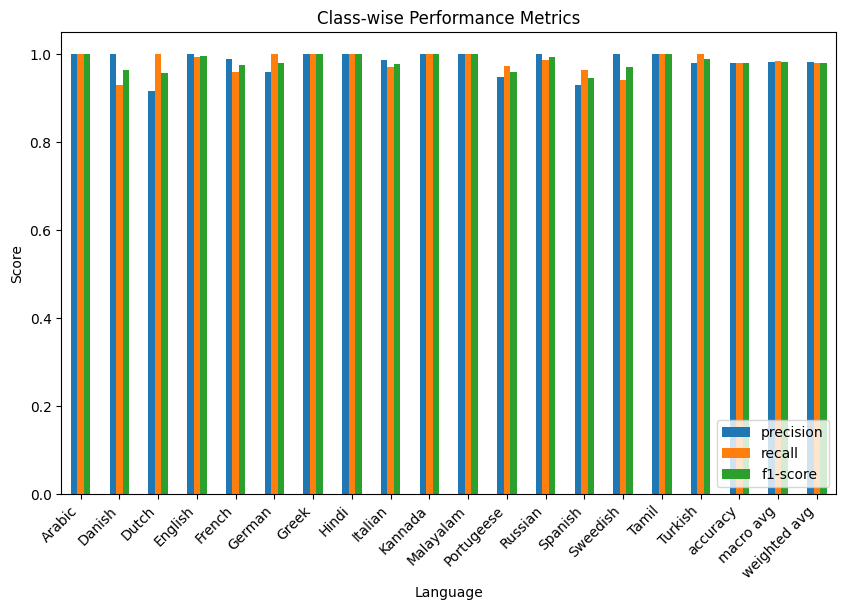

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(testing_labels, predictions_test, target_names=class_names, output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
metrics_df.drop(columns=['support'], inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Class-wise Performance Metrics')
plt.xlabel('Language')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.show()


LOGISTIC REGRESSION MODEL

In [ ]:
# Split your data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df["Text"], df["Language"], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
# Define pipeline with TF-IDF Vectorizer and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])




In [ ]:
# Define hyperparameter grid
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1, 10],
}

In [ ]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train_val, y_train_val)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.1, 1, 10],
                         'tfidf__max_features': [1000, 2000, 3000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [ ]:
# Print best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'clf__C': 1, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}
Best Score: 0.9472737645074271


In [ ]:
Logistic_best_model = grid_search.best_estimator_

**Running test set**

In [ ]:
# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, Logistic_best_model.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9492


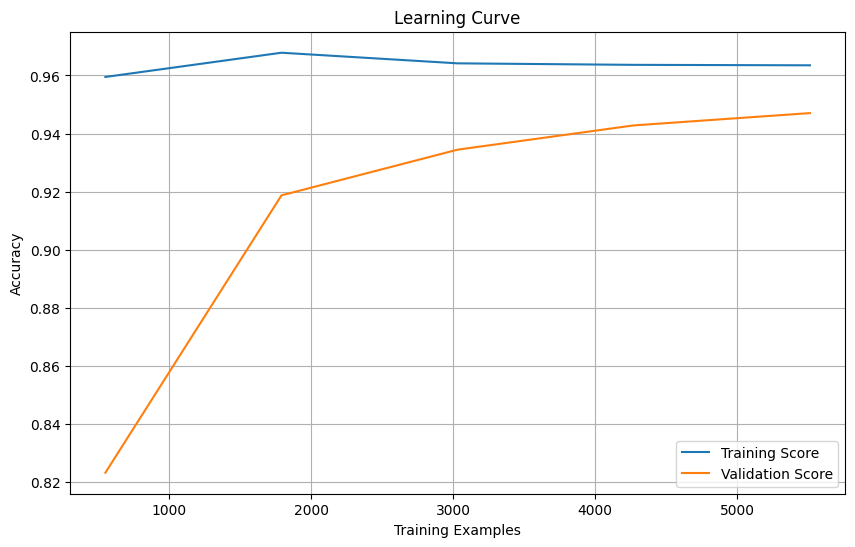

In [ ]:
from sklearn.model_selection import learning_curve

# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(Logistic_best_model, X_train_val, y_train_val, cv=3, scoring='accuracy')
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

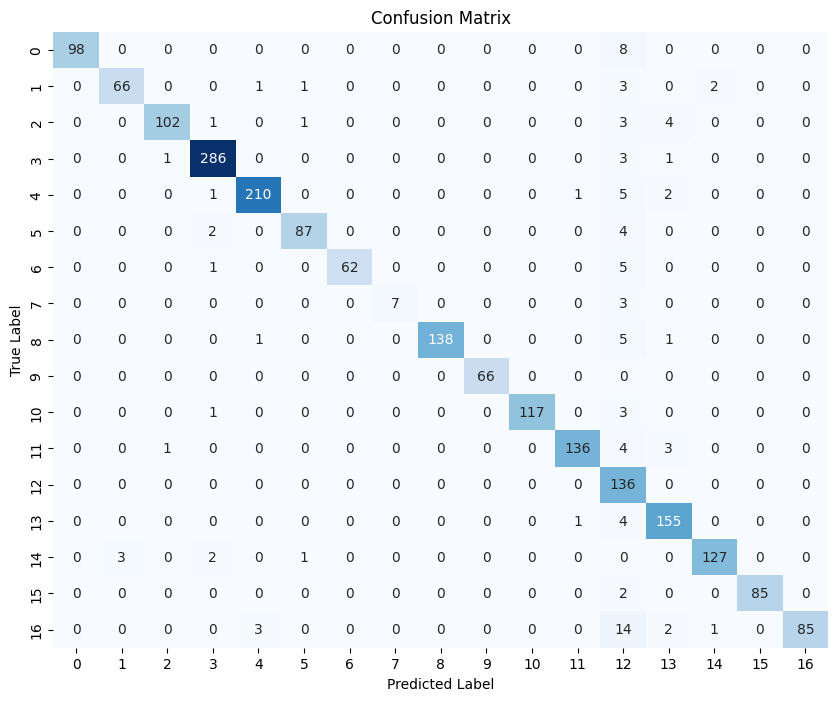

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test set
y_pred = Logistic_best_model.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

MULTINOMIAL NB


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Define pipeline with TF-IDF Vectorizer and Multinomial Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [ ]:
# Define hyperparameter grid
param_grid_nb = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__alpha': [0.1, 1, 10],  # Alpha parameter for Laplace smoothing
}



In [ ]:
# Perform grid search with cross-validation
grid_search_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=3, scoring='accuracy', verbose=1)
grid_search_nb.fit(X_train_val, y_train_val)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.1, 1, 10],
                         'tfidf__max_features': [1000, 2000, 3000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [ ]:
# Print best hyperparameters and best score
print("Best Hyperparameters:", grid_search_nb.best_params_)
print("Best Score:", grid_search_nb.best_score_)

Best Hyperparameters: {'clf__alpha': 0.1, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}
Best Score: 0.9495712106527799


In [ ]:
# Evaluate the best model on the test set
best_model_nb = grid_search_nb.best_estimator_
test_accuracy_nb = accuracy_score(y_test, best_model_nb.predict(X_test))
print(f"Test Accuracy: {test_accuracy_nb:.4f}")

Test Accuracy: 0.9502


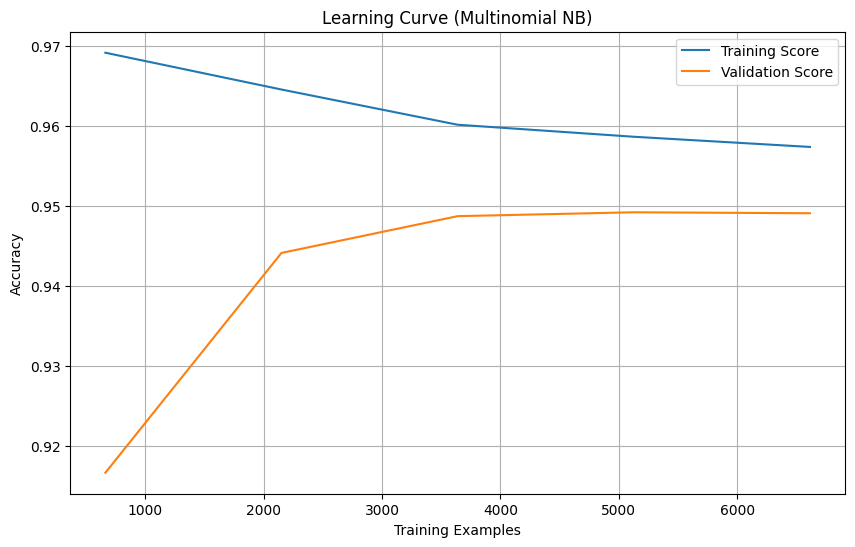

In [ ]:
from sklearn.model_selection import learning_curve

# Plot learning curve
train_sizes_nb, train_scores_nb, val_scores_nb = learning_curve(best_model_nb, X_train_val, y_train_val, cv=5, scoring='accuracy')
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_nb, np.mean(train_scores_nb, axis=1), label='Training Score')
plt.plot(train_sizes_nb, np.mean(val_scores_nb, axis=1), label='Validation Score')
plt.title('Learning Curve (Multinomial NB)')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Running Test set**

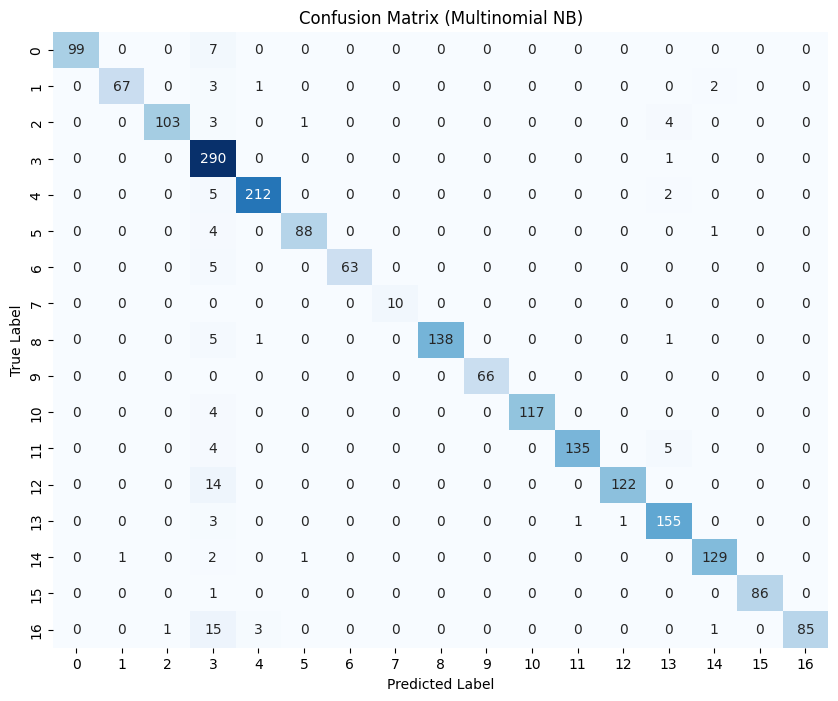

In [ ]:
# Get predictions on the test set
y_pred_nb = best_model_nb.predict(X_test)

# Compute confusion matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Multinomial NB)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import joblib
# Save MultinomialNB model
multinomialNB_model_path = "multinomialNB_model.pkl"
joblib.dump(best_model_nb, multinomialNB_model_path)


['multinomialNB_model.pkl']

In [ ]:
# Save Logistic Regression model
logistic_regression_model_path = "logistic_regression_model.pkl"
joblib.dump(Logistic_best_model, logistic_regression_model_path)

['logistic_regression_model.pkl']

In [ ]:
# Save BERT model
bert_model_path = "bert_model.pkl"
joblib.dump(bert_model, bert_model_path)

['bert_model.pkl']